In [35]:
import os
import wfdb
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import joblib
from scipy.fftpack import fft

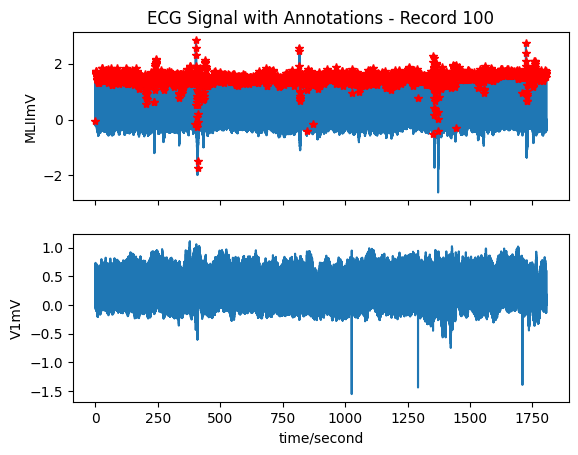

First 10 ECG Signal values: [[-0.08   0.135]
 [-0.08   0.135]
 [-0.08   0.135]
 [-0.08   0.135]
 [-0.08   0.135]
 [-0.08   0.135]
 [-0.08   0.135]
 [-0.08   0.135]
 [-0.075  0.135]
 [-0.075  0.145]]
First 10 annotation sample locations: [  52  135  366  606  841 1082 1327 1562 1794 2042]
First 10 annotation symbols: ['+', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N', 'N']


In [24]:
# Define the path to the folder where the MIT-BIH files are located
data_dir = r'C:\stasi\SoftUni_Machine_learning\mit-bih-arrhythmia-database-1.0.0\mit-bih-arrhythmia-database-1.0.0'

# List of record numbers to process
record_numbers = ['100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '111', '112', '113', '114', '115', 
                  '116', '117', '118', '119', '121', '122', '123', '124', '200', '201', '202', '203', '205', '207', 
                  '208', '209', '210', '212', '213', '214', '215', '217', '219', '220', '221', '222', '223', '228', 
                  '230', '231', '232', '233', '234']

# Load a specific record (for example, record 100)
for record_number in record_numbers:
    record_path = os.path.join(data_dir, record_number)  # Dynamically generate record path

# Load the ECG signal and annotation
record = wfdb.rdrecord(record_path)  # Load the ECG signal
annotation = wfdb.rdann(record_path, 'atr')  # Load the annotations

# Plot the ECG signal along with annotations
wfdb.plot_wfdb(record=record, annotation=annotation, title='ECG Signal with Annotations - Record 100')

# Access the ECG signal and annotations
ecg_signal = record.p_signal
ann_sample = annotation.sample  # Annotation sample locations
ann_symbols = annotation.symbol  # Types of annotations (arrhythmias)

# Example: Print first 10 samples of the signal and annotations
print("First 10 ECG Signal values:", ecg_signal[:10])
print("First 10 annotation sample locations:", ann_sample[:10])
print("First 10 annotation symbols:", ann_symbols[:10])

In [7]:
rr_intervals = np.diff(ann_sample) / record.fs  # RR intervals in seconds
print("First 10 RR intervals:", rr_intervals[:10])

First 10 RR intervals: [0.23055556 0.64166667 0.66666667 0.65277778 0.66944444 0.68055556
 0.65277778 0.64444444 0.68888889 0.68611111]


In [27]:
# Split the record numbers into training (80%) and testing (20%) sets
train_records = record_numbers[:int(0.8 * len(record_numbers))]  # First 80% for training
test_records = record_numbers[int(0.8 * len(record_numbers)):]   # Remaining 20% for testing

# Initialize empty lists to hold features and labels for training and testing
train_rr_intervals = []
train_labels = []

test_rr_intervals = []
test_labels = []

# Function to process records and extract features and labels
def process_records(record_list, rr_intervals_list, labels_list):
    for record_number in record_list:
        record_path = os.path.join(data_dir, record_number)
        try:
            # Load the record and annotations
            record = wfdb.rdrecord(record_path)
            annotation = wfdb.rdann(record_path, 'atr')

            # Extract RR intervals and labels for each beat
            rr_intervals = np.diff(annotation.sample) / record.fs  # RR intervals in seconds
            labels = [1 if sym == 'N' else 0 for sym in annotation.symbol[:-1]]  # 1 for normal, 0 for others

            # Append to the corresponding dataset
            rr_intervals_list.extend(rr_intervals)
            labels_list.extend(labels)

        except Exception as e:
            print(f"Could not process record {record_number}: {e}")

# Process training records
process_records(train_records, train_rr_intervals, train_labels)

# Process testing records
process_records(test_records, test_rr_intervals, test_labels)

# Convert lists to numpy arrays
X_train = np.array(train_rr_intervals).reshape(-1, 1)  # RR intervals as features (training)
y_train = np.array(train_labels)  # Labels (training)

X_test = np.array(test_rr_intervals).reshape(-1, 1)  # RR intervals as features (testing)
y_test = np.array(test_labels)  # Labels (testing)

# Train an SVM model on the training data
clf = SVC()
clf.fit(X_train, y_train)

# Evaluate the model on the test data
accuracy = clf.score(X_test, y_test)
print(f"Model Accuracy on Test Data: {accuracy * 100:.2f}%")

Model Accuracy on Test Data: 59.64%


In [13]:
# Define the parameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf', 'poly', 'sigmoid']
}

# Perform grid search
grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=2)
grid.fit(X_train, y_train)

# Evaluate the best model
print(f"Best parameters: {grid.best_params_}")
accuracy = grid.score(X_test, y_test)

print(f"Optimized SVM Accuracy on Test Data: {accuracy * 100:.2f}%")

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time= 4.4min
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time= 3.1min
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time= 4.0min
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time=67.3min
[CV] END .........................C=0.1, gamma=1, kernel=rbf; total time= 4.6min
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time= 1.6min
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time= 1.9min
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time= 1.8min
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time= 1.9min
[CV] END ........................C=0.1, gamma=1, kernel=poly; total time= 1.8min
[CV] END .....................C=0.1, gamma=1, kernel=sigmoid; total time= 2.1min
[CV] END .....................C=0.1, gamma=1, k

In [14]:
from sklearn.metrics import classification_report

# Generate predictions on the test set
y_pred = grid.predict(X_test)

# Print classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.11      0.19      6893
           1       0.74      0.99      0.84     17255

    accuracy                           0.74     24148
   macro avg       0.78      0.55      0.52     24148
weighted avg       0.76      0.74      0.66     24148



In [15]:
clf = SVC(class_weight={0: 2, 1: 1})  # Assign higher weight to class 0
clf.fit(X_train, y_train)

SVC(class_weight={0: 2, 1: 1})

In [19]:
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)

# Train the model on the balanced dataset
clf = SVC()
clf.fit(X_res, y_res)

SVC()

In [20]:
clf = RandomForestClassifier(class_weight='balanced')
clf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced')

In [26]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.28      0.31      0.29      6893
           1       0.71      0.67      0.69     17255

    accuracy                           0.57     24148
   macro avg       0.49      0.49      0.49     24148
weighted avg       0.59      0.57      0.58     24148



In [29]:
y_pred = clf.predict(X_test)

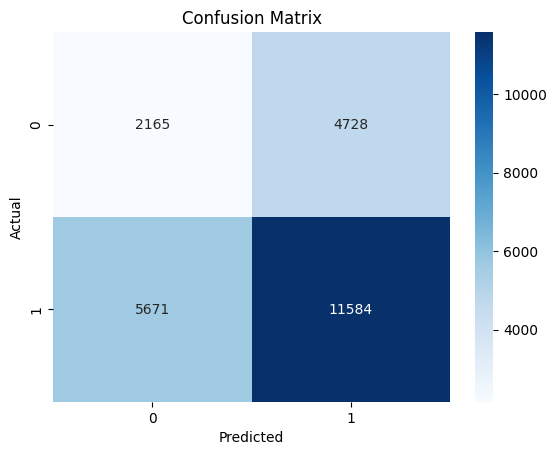

In [30]:
# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1], yticklabels=[0, 1])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

In [31]:
# Generate the classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.28      0.31      0.29      6893
           1       0.71      0.67      0.69     17255

    accuracy                           0.57     24148
   macro avg       0.49      0.49      0.49     24148
weighted avg       0.59      0.57      0.58     24148



In [34]:
# Perform 5-fold cross-validation
scores = cross_val_score(clf, X_train, y_train, cv=5)
print(f"Cross-validation scores: {scores}")
print(f"Mean cross-validation accuracy: {scores.mean() * 100:.2f}%")

Cross-validation scores: [0.67277147 0.66924816 0.67642736 0.6611645  0.74448841]
Mean cross-validation accuracy: 68.48%


In [11]:
# Train a Random Forest model
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Evaluate the model
accuracy = clf.score(X_test, y_test)
print(f"Random Forest Accuracy on Test Data: {accuracy * 100:.2f}%")

Random Forest Accuracy on Test Data: 63.66%


In [35]:
# Initialize the Random Forest model with class weights to handle imbalance
clf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)

# Train the model
clf.fit(X_train, y_train)

# Evaluate the model on the test data
accuracy = clf.score(X_test, y_test)
print(f"Random Forest Accuracy on Test Data: {accuracy * 100:.2f}%")

# Cross-validation to assess the performance stability
cv_scores = cross_val_score(clf, X_train, y_train, cv=5)
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation accuracy: {cv_scores.mean() * 100:.2f}%")

Random Forest Accuracy on Test Data: 56.96%
Cross-validation scores: [0.67017127 0.66975692 0.6745619  0.65421142 0.74471453]
Mean cross-validation accuracy: 68.27%


              precision    recall  f1-score   support

           0       0.83      0.11      0.19      6893
           1       0.74      0.99      0.84     17255

    accuracy                           0.74     24148
   macro avg       0.78      0.55      0.52     24148
weighted avg       0.76      0.74      0.66     24148



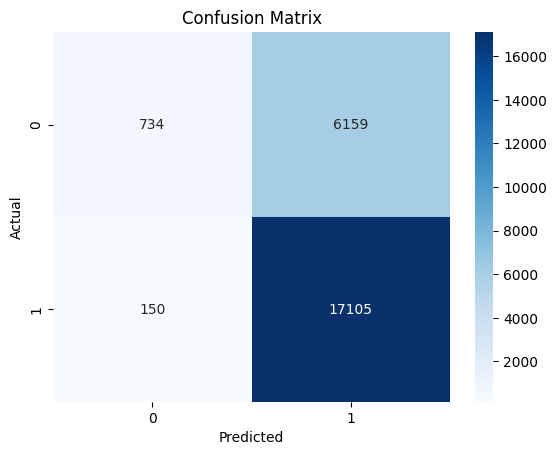

In [28]:
# Manually define the SVM model with the best parameters
best_svm_model = SVC(C=100, gamma=1, kernel='rbf')

# Fit the model on the training data
best_svm_model.fit(X_train, y_train)

# Generate predictions on the test data
y_pred = best_svm_model.predict(X_test)

# Print classification report
print(classification_report(y_test, y_pred))

# Create a confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

In [31]:
# Save the optimized model
joblib.dump(best_svm_model, 'optimized_svm_model.pkl')

# To load the model later
loaded_model = joblib.load('optimized_svm_model.pkl')

In [32]:
arrhythmia_map = {'N': 0, 'A': 1, 'L': 2, 'R': 3, 'V': 4, 'F': 5, 'Q': 6}

In [33]:
rr_intervals = np.diff(annotation.sample) / record.fs  # RR intervals in seconds

In [36]:
fft_features = fft(ecg_signal)

              precision    recall  f1-score   support

           0       0.83      0.11      0.19      6893
           1       0.74      0.99      0.84     17255

    accuracy                           0.74     24148
   macro avg       0.78      0.55      0.52     24148
weighted avg       0.76      0.74      0.66     24148



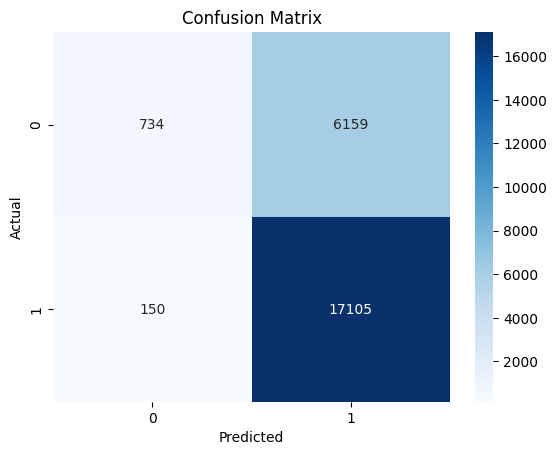

In [37]:
# Load the previously saved optimized SVM model
best_svm_model = joblib.load('optimized_svm_model.pkl')
y_pred = best_svm_model.predict(X_test)
# Print the classification report
print(classification_report(y_test, y_pred))

# Generate and plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

In [38]:
# Adjust class weights
best_svm_model = SVC(C=100, gamma=1, kernel='rbf', class_weight={0: 10, 1: 1})
best_svm_model.fit(X_train, y_train)
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)

# Train the SVM model on the balanced dataset
best_svm_model.fit(X_res, y_res)


SVC(C=100, class_weight={0: 10, 1: 1}, gamma=1)

In [39]:
# Create the SVM model with adjusted class weights
best_svm_model = SVC(C=100, class_weight={0: 10, 1: 1}, gamma=1, kernel='rbf')

# Train the model on the training data
best_svm_model.fit(X_train, y_train)

SVC(C=100, class_weight={0: 10, 1: 1}, gamma=1)

c:\stasi\SoftUni_Math_Concepts\Lecture_1\math_concepts\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\stasi\SoftUni_Math_Concepts\Lecture_1\math_concepts\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\stasi\SoftUni_Math_Concepts\Lecture_1\math_concepts\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

              precision    recall  f1-score   support

           0       0.29      1.00      0.44      6893
           1       0.00      0.00      0.00     17255

    accuracy                           0.29     24148
   macro avg       0.14      0.50      0.22     24148
weighted avg       0.08      0.29      0.13     24148



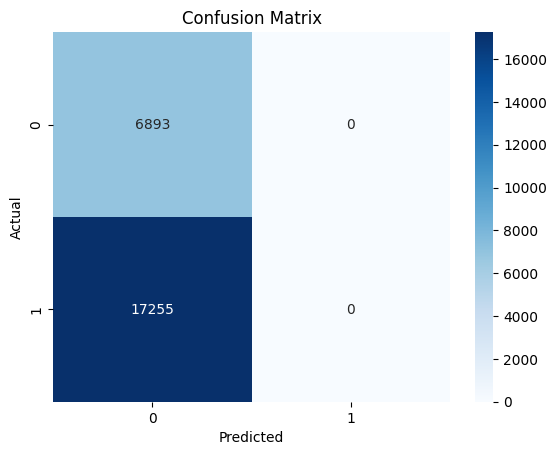

In [40]:
# Generate predictions on the test set
y_pred = best_svm_model.predict(X_test)

# Print the classification report
print(classification_report(y_test, y_pred))

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

In [42]:
best_svm_model = SVC(C=100, class_weight={0: 3, 1: 1}, gamma=1, kernel='rbf')
param_grid = {
    'C': [100],
    'gamma': [1],
    'kernel': ['rbf'],
    'class_weight': [{0: 2, 1: 1}, {0: 3, 1: 1}, {0: 5, 1: 1}]
}

grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=2)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] END C=100, class_weight={0: 2, 1: 1}, gamma=1, kernel=rbf; total time= 5.3min
[CV] END C=100, class_weight={0: 2, 1: 1}, gamma=1, kernel=rbf; total time= 4.2min
[CV] END C=100, class_weight={0: 2, 1: 1}, gamma=1, kernel=rbf; total time= 3.9min
[CV] END C=100, class_weight={0: 2, 1: 1}, gamma=1, kernel=rbf; total time=28.8min
[CV] END C=100, class_weight={0: 2, 1: 1}, gamma=1, kernel=rbf; total time= 4.4min
[CV] END C=100, class_weight={0: 3, 1: 1}, gamma=1, kernel=rbf; total time= 3.9min
[CV] END C=100, class_weight={0: 3, 1: 1}, gamma=1, kernel=rbf; total time= 4.5min
[CV] END C=100, class_weight={0: 3, 1: 1}, gamma=1, kernel=rbf; total time= 4.5min
[CV] END C=100, class_weight={0: 3, 1: 1}, gamma=1, kernel=rbf; total time= 5.7min
[CV] END C=100, class_weight={0: 3, 1: 1}, gamma=1, kernel=rbf; total time= 4.4min
[CV] END C=100, class_weight={0: 5, 1: 1}, gamma=1, kernel=rbf; total time= 4.7min
[CV] END C=100, class_weigh

GridSearchCV(estimator=SVC(),
             param_grid={'C': [100],
                         'class_weight': [{0: 2, 1: 1}, {0: 3, 1: 1},
                                          {0: 5, 1: 1}],
                         'gamma': [1], 'kernel': ['rbf']},
             verbose=2)

In [43]:
best_svm_model = grid.best_estimator_

# Print the best parameters
print(f"Best parameters: {grid.best_params_}")

Best parameters: {'C': 100, 'class_weight': {0: 2, 1: 1}, 'gamma': 1, 'kernel': 'rbf'}


              precision    recall  f1-score   support

           0       0.37      0.74      0.50      6893
           1       0.83      0.50      0.63     17255

    accuracy                           0.57     24148
   macro avg       0.60      0.62      0.56     24148
weighted avg       0.70      0.57      0.59     24148



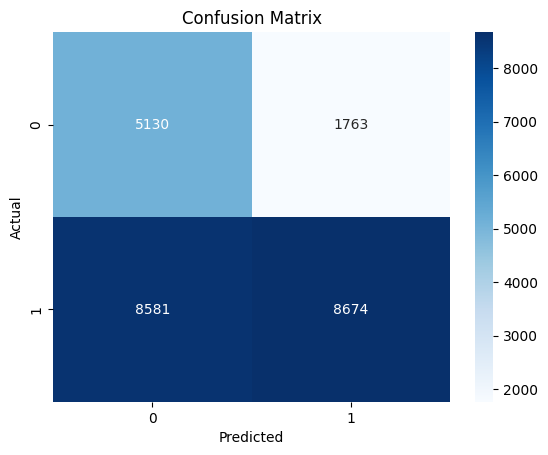

In [44]:
# Generate predictions on the test set
y_pred = best_svm_model.predict(X_test)

# Print the classification report
print(classification_report(y_test, y_pred))

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

In [45]:
import joblib

# Save the best model to a file
joblib.dump(best_svm_model, 'optimized_svm_model.pkl')

print("Model saved successfully!")

Model saved successfully!
